In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import copy

# naive algo

/home/jaime/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jaime/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


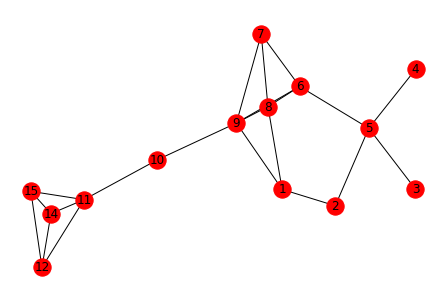

In [3]:
g = nx.Graph([])
g.add_edges_from([(1,2),(1,8),(1,9),
                  (5,2),
                  (5,3),
                  (5,4),
                  (5,6),
                  (6,7),
                  (6,8),
                  (6,9),
                  (7,8),
                  (7,9),
                  (8,9),
                  (9,10),
                  (10,11),
                  (11,14),
                  (11,15),
                  (11,12),
                  (14,15),
                  (15,12),
                  (12,14)
                 ])
nx.draw(g,with_labels=True)
plt.show()

In [4]:
nx.core_number(g)

{1: 2,
 2: 2,
 8: 3,
 9: 3,
 5: 2,
 3: 1,
 4: 1,
 6: 3,
 7: 3,
 10: 2,
 11: 3,
 14: 3,
 15: 3,
 12: 3}

In [5]:
def naive_approach(g):
    gg = copy.deepcopy(g)
    weights = dict(gg.degree)

    cores_g = dict(zip(gg.nodes,[0]*len(gg.nodes)))

    while len(gg.nodes) > 0:
        index_top , min_degree   = min(weights.items(), key=itemgetter(1))
        neighbors = list(gg.neighbors(index_top))
        cores_g[index_top] = min_degree
        gg.remove_node(index_top)
        weights.pop(index_top)

        if neighbors:
            new_degrees=gg.degree()
            for neigh in neighbors:
                weights[neigh] = max(min_degree,new_degrees[neigh])
                
    return cores_g

In [6]:
naive_approach(g)==nx.core_number(g)

True

# Approach 1

In [7]:
def core_number_1(G):
    degrees = dict(G.degree())
    nodes = sorted(degrees, key=degrees.get)
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    i=0
    count_passed_through = []
    while len(count_passed_through)<len(nodes):
        nodes = sorted(degrees, key=degrees.get)       
        st =  set(count_passed_through)
        v = [ele for ele in nodes if ele not in st][0]  ### check mainting order

        for u in nbrs[v]:
            if degrees[u] > degrees[v]:
                degrees[u] -= 1
                
        count_passed_through.append(v)

    return degrees

In [8]:
core_number_1_p(g)==nx.core_number(g)

NameError: name 'core_number_1_p' is not defined

In [9]:
core_number_1(g)==nx.core_number(g)

True

In [10]:
nx.core_number(g)

{1: 2,
 2: 2,
 8: 3,
 9: 3,
 5: 2,
 3: 1,
 4: 1,
 6: 3,
 7: 3,
 10: 2,
 11: 3,
 14: 3,
 15: 3,
 12: 3}

## parallel

In [11]:
from joblib import Parallel, delayed
import multiprocessing

In [12]:
from multiprocessing import Pool

In [13]:
def core_number_1_refactored(G):
    
    def update_terms(a,b):
        a = a- 1*(a > b)
        return a
        
    num_cores = multiprocessing.cpu_count()
    degrees = dict(G.degree())
    nodes = sorted(degrees, key=degrees.get)
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    i=0
    count_passed_through = []
    while len(count_passed_through)<len(nodes):
        nodes = sorted(degrees, key=degrees.get)       
        st =  set(count_passed_through)
        v = [ele for ele in nodes if ele not in st][0]  ### check mainting order
        
#         new_cores = [update_terms(degrees[u] ,degrees[v]) for u in nbrs[v]]
        new_cores = Parallel(n_jobs=num_cores, verbose=0)(delayed(update_terms)(degrees[u] ,degrees[v])for u in nbrs[v])
        degrees.update(dict(zip(nbrs[v], new_cores)))
    
        
#         squares = Parallel(n_jobs=num_cores, verbose=50)(delayed(find_square)(i)for i in my_list)
#         Parallel(n_jobs=num_cores, verbose=50)(delayed(update_cores)(degrees,u,v)for u in nbrs[v])
#         print(degrees)
#         for u in nbrs[v]:
#             update_cores(degrees,u,v)
                
        count_passed_through.append(v)

    return degrees

In [14]:
mydict

NameError: name 'mydict' is not defined

In [15]:
my_list = range(10)
squares = []

# Function to parallelize
def find_square(i):
    return i ** 2
def update_cores(degrees,u,v):
    degrees[u] -= 1*(degrees[u] > degrees[v])

# # # With parallel processing
# num_cores = multiprocessing.cpu_count()
# squares = Parallel(n_jobs=num_cores, verbose=50)(delayed(
#     find_square)(i)for i in my_list)

In [16]:
core_number_1_refactored(g)==nx.core_number(g)

True

# Best approach (nx code, reformaté)

In [17]:
def core_number(G):

    degrees = dict(G.degree())
    # Sort nodes by degree.
    nodes = sorted(degrees, key=degrees.get)
    bin_boundaries = [0]
    curr_degree = 0
    for i, v in enumerate(nodes):
        if degrees[v] > curr_degree:
            bin_boundaries.extend([i] * (degrees[v] - curr_degree))
            curr_degree = degrees[v]
    node_pos = {v: pos for pos, v in enumerate(nodes)}
    
    # The initial guess for the core number of a node is its degree.
    core = degrees
    nbrs = {v: list(nx.all_neighbors(G, v)) for v in G}
    for v in nodes:
        for u in nbrs[v]:
            if core[u] > core[v]:
                nbrs[u].remove(v)
                pos = node_pos[u]
                bin_start = bin_boundaries[core[u]]
                node_pos[u] = bin_start
                node_pos[nodes[bin_start]] = pos
                nodes[bin_start], nodes[pos] = nodes[pos], nodes[bin_start]
                bin_boundaries[core[u]] += 1
                core[u] -= 1
    return core

In [18]:
core_number(g)==nx.core_number(g)

True

# scalable algo sequential

In [19]:
def seq_max_k_core(G):

    peel = 1
    Q = []
    num_active = G.number_of_nodes()
    G_nodes = tuple(G.nodes)
    flag = {v: 0 for v in G_nodes}
    deg = dict(G.degree())

    while num_active > 0:
        Vb = []
        not_flagged = {n for n in G_nodes if flag[n] == 0}

        # This loop can be parallelized
        for n in not_flagged:
            if deg[n] <= peel:
                flag[n] = 1
                Vb.append(n)
        Q = set(Q) | set(Vb)
        num_active -= len(Vb)

        if Vb:
            # This loop can be parallelized
            for u in Vb:
                for v in G.neighbors(u):
                    deg[u] -= 1
                    deg[v] -= 1
        else:
            peel += 1
            Q = []

    return G.subgraph(Q), peel

In [20]:
peels

NameError: name 'peels' is not defined

In [21]:
peels[1]

NameError: name 'peels' is not defined

In [22]:
def seq_k_core_decompo(G):

    G = G.copy()
    peels = dict.fromkeys(G.nodes,0)
    G.remove_nodes_from(list(nx.isolates(G)))

    while list(G.nodes):
        print(G.nodes)
        K, k_num = seq_max_k_core(G)
#         plot_graph(K)
        # This loop can be parallelized
        for n in K.nodes:
            peels[n] = max(k_num,peels[n])
            
        nx.draw(G,with_labels=True)
        plt.show()

        G.remove_edges_from(list(K.edges))
#         G.remove_nodes_from(list(K.nodes))
        nx.draw(G,with_labels=True)
        plt.show()

        G.remove_nodes_from(list(nx.isolates(G)))

    return peels

[1, 2, 8, 9, 5, 3, 4, 6, 7, 10, 11, 14, 15, 12]


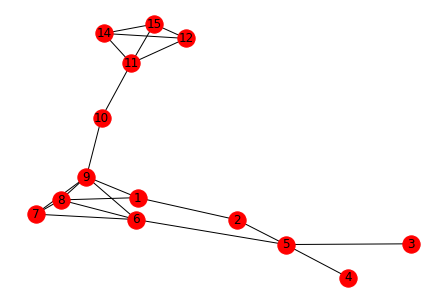

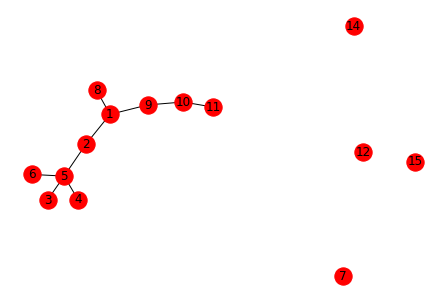

[1, 2, 8, 9, 5, 3, 4, 6, 10, 11]


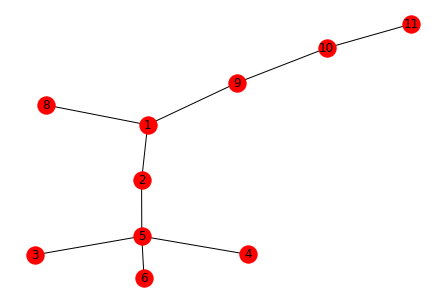

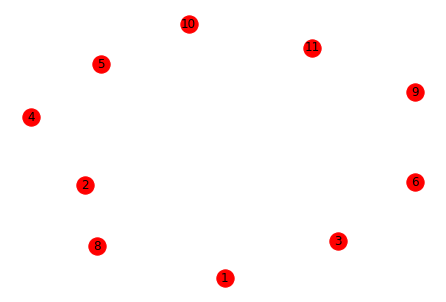

{1: 1,
 2: 1,
 8: 3,
 9: 3,
 5: 1,
 3: 1,
 4: 1,
 6: 3,
 7: 3,
 10: 1,
 11: 3,
 14: 3,
 15: 3,
 12: 3}

In [23]:
seq_k_core_decompo(g)

In [24]:
nx.core_number(g)

{1: 2,
 2: 2,
 8: 3,
 9: 3,
 5: 2,
 3: 1,
 4: 1,
 6: 3,
 7: 3,
 10: 2,
 11: 3,
 14: 3,
 15: 3,
 12: 3}

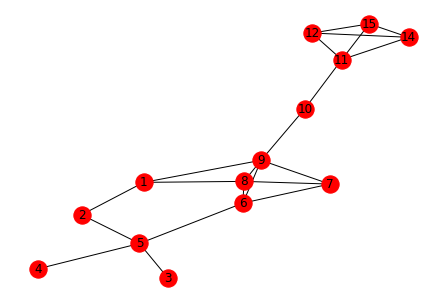

In [25]:
g2=g.copy()
nx.draw(g2,with_labels=True)
plt.show()

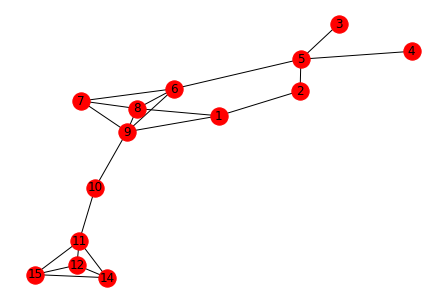

In [26]:
peels = {}
g2.remove_nodes_from(list(nx.isolates(g2)))

nx.draw(g2,with_labels=True)
plt.show()

In [27]:
K, k_num = seq_max_k_core(g2)
K, k_num

(<networkx.classes.graph.Graph at 0x7f1bdc44ffd0>, 3)

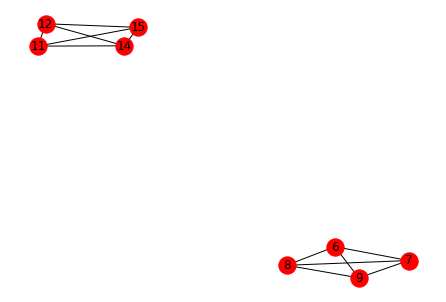

In [28]:
nx.draw(K,with_labels=True)
plt.show()

In [29]:
g2.remove_edges_from(list(K.edges))

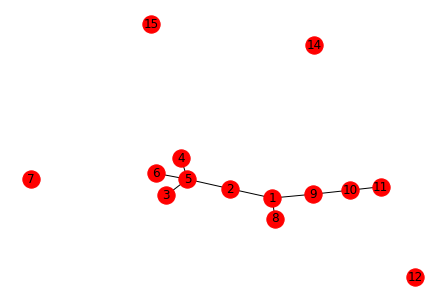

In [30]:
nx.draw(g2,with_labels=True)
plt.show()

In [31]:
g2.remove_nodes_from(list(nx.isolates(g2)))

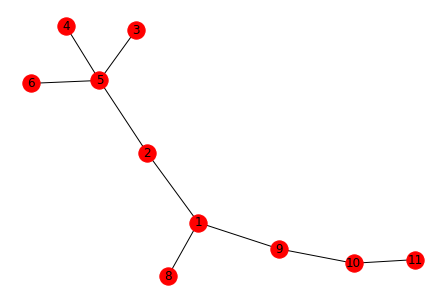

In [32]:
nx.draw(g2,with_labels=True)
plt.show()

In [33]:
nx.core_number(g)

{1: 2,
 2: 2,
 8: 3,
 9: 3,
 5: 2,
 3: 1,
 4: 1,
 6: 3,
 7: 3,
 10: 2,
 11: 3,
 14: 3,
 15: 3,
 12: 3}

[1, 2, 8, 9, 5, 3, 4, 6, 7, 10, 11, 14, 15, 12]


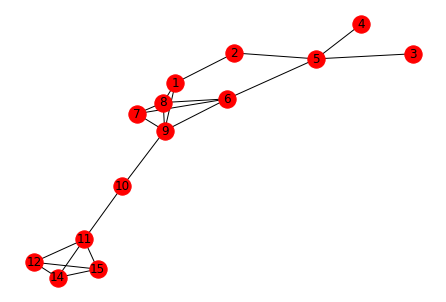

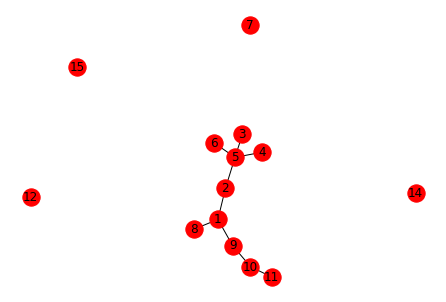

[1, 2, 8, 9, 5, 3, 4, 6, 10, 11]


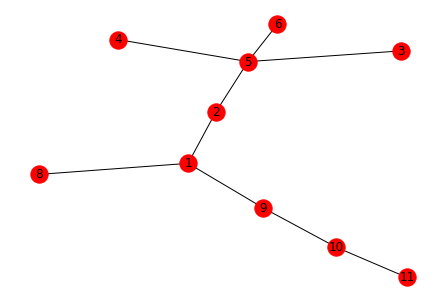

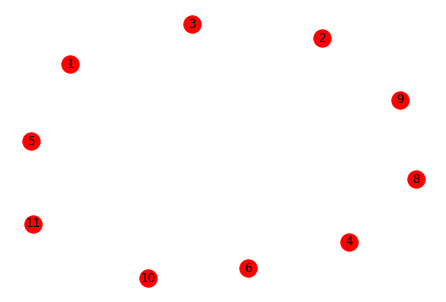

{1: 1,
 2: 1,
 8: 3,
 9: 3,
 5: 1,
 3: 1,
 4: 1,
 6: 3,
 7: 3,
 10: 1,
 11: 3,
 14: 3,
 15: 3,
 12: 3}

In [34]:
seq_k_core_decompo(g)

# approach comparison

In [35]:
# bigger graph to test

In [106]:
G = nx.duplication_divergence_graph(3500,0.5)

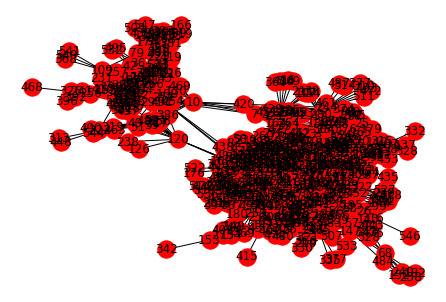

In [100]:
nx.draw(G,with_labels=True)
plt.show()

In [101]:
nx.core_number(G)

{0: 5,
 1: 7,
 2: 5,
 3: 5,
 4: 7,
 5: 1,
 6: 7,
 7: 5,
 8: 5,
 9: 7,
 10: 4,
 11: 4,
 12: 3,
 13: 6,
 14: 7,
 15: 1,
 16: 1,
 17: 3,
 18: 5,
 19: 5,
 20: 7,
 21: 4,
 22: 5,
 23: 4,
 24: 7,
 25: 3,
 26: 3,
 27: 1,
 28: 5,
 29: 4,
 30: 7,
 31: 7,
 32: 7,
 33: 7,
 34: 7,
 35: 6,
 36: 4,
 37: 5,
 38: 2,
 39: 1,
 40: 3,
 41: 7,
 42: 4,
 43: 4,
 44: 4,
 45: 7,
 46: 7,
 47: 7,
 48: 7,
 49: 4,
 50: 1,
 51: 3,
 52: 6,
 53: 2,
 54: 6,
 55: 5,
 56: 6,
 57: 3,
 58: 1,
 59: 2,
 60: 6,
 61: 4,
 62: 6,
 63: 1,
 64: 7,
 65: 4,
 66: 5,
 67: 7,
 68: 3,
 69: 1,
 70: 6,
 71: 2,
 72: 1,
 73: 7,
 74: 7,
 75: 7,
 76: 4,
 77: 6,
 78: 4,
 79: 4,
 80: 7,
 81: 4,
 82: 7,
 83: 1,
 84: 5,
 85: 5,
 86: 6,
 87: 7,
 88: 2,
 89: 1,
 90: 2,
 91: 4,
 92: 1,
 93: 7,
 94: 2,
 95: 7,
 96: 7,
 97: 5,
 98: 4,
 99: 2,
 100: 5,
 101: 2,
 102: 6,
 103: 3,
 104: 4,
 105: 5,
 106: 7,
 107: 2,
 108: 3,
 109: 4,
 110: 6,
 111: 2,
 112: 2,
 113: 7,
 114: 7,
 115: 7,
 116: 2,
 117: 5,
 118: 1,
 119: 5,
 120: 4,
 121: 1,
 122: 2,
 12

In [118]:
import timeit


## time

In [107]:
%timeit naive_approach(G)

933 ms ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
%timeit core_number_1(G)

4.08 s ± 1.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [112]:
%timeit core_number_1_refactored(G)

29.1 s ± 4.66 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [113]:
%timeit nx.core_number(G)

30.2 ms ± 564 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## memory usage

In [ ]:
# pip install memory_profiler

In [115]:
%load_ext memory_profiler

In [116]:
%memit naive_approach(g)

peak memory: 214.36 MiB, increment: 0.00 MiB


In [117]:
%memit core_number(g)

peak memory: 214.36 MiB, increment: 0.00 MiB
